# M1M3 position data
Craig Lage - 16-Apr-23 \
Modified 17-Nov-23 \
This is evaluating M1M3 position stability in support of SITCOM-797

## Prepare the notebook

In [1]:
# Directory to store the data
from pathlib import Path
data_dir = Path("./plots")
data_dir.mkdir(exist_ok=True, parents=True)

# These are the times for the large elevation slew plot
t_start = "2023-07-11T18:53:30" 
t_end = "2023-07-11T18:58:00"

# Now these are the day of a large number of slews
dayObs = 20230802

# These are the times of the different blocks with different max speed limits
# and the corresponding speed limits
blockTimes = ["2023-08-02T21:44:00", "2023-08-03T01:14:00", "2023-08-03T03:06:00", \
              "2023-08-03T05:01:00", "2023-08-03T06:00:00"]
azMaxLimits = [30.0, 40.0, 50.0, 20.0]
elMaxLimits = [30.0, 30.0, 30.0, 20.0]

In [2]:
import sys, time, os, asyncio, glob
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pickle as pkl
from astropy.time import Time, TimeDelta
from scipy.interpolate import UnivariateSpline
from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState, getSlewsFromEventList
from lsst_efd_client import EfdClient

In [3]:
client = EfdClient("idf_efd")
eventMaker = TMAEventMaker()

# Get the data for the large elevation slew plot

In [4]:
start = Time(t_start, scale='utc')
end = Time(t_end, scale='utc')
hardpoint_data = await client.select_time_series("lsst.sal.MTM1M3.hardpointActuatorData", "*", start, end)
monitor_data = await client.select_time_series("lsst.sal.MTM1M3.hardpointMonitorData", "*", start, end)
ims_data = await client.select_time_series("lsst.sal.MTM1M3.imsData", "*", start, end)
az = await client.select_time_series("lsst.sal.MTMount.azimuth","actualPosition", start, end)
el = await client.select_time_series("lsst.sal.MTMount.elevation","actualPosition", start, end)
azs = az['actualPosition'].values
dAz = azs[-1] - azs[0]
els = el['actualPosition'].values
dEl = els[-1] - els[0]
timestamp = start.isot.split('.')[0].replace('-','').replace(':','')

# Now make the large elevation slew plot

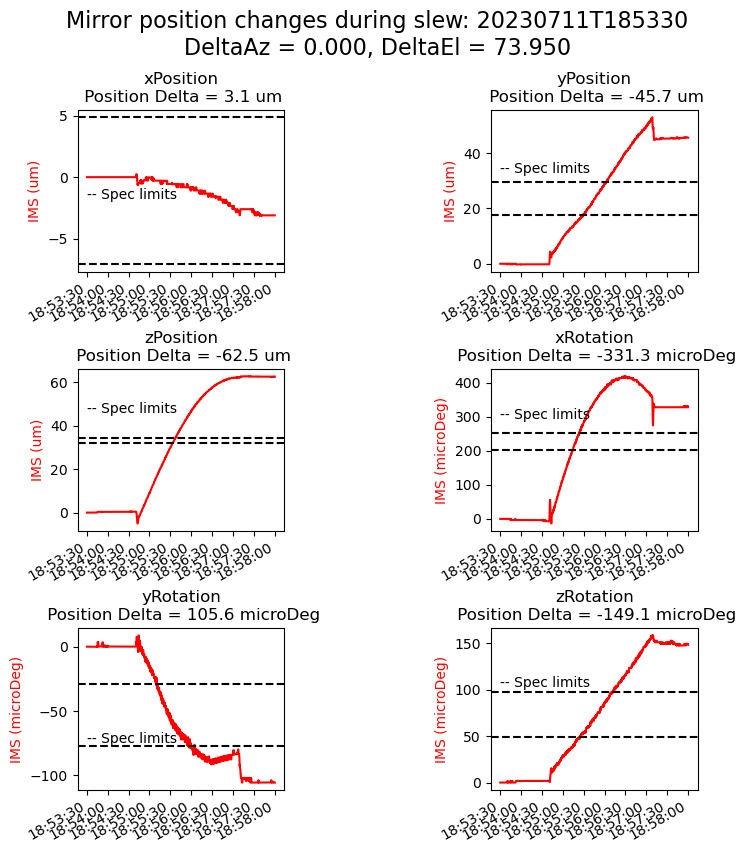

In [8]:
%matplotlib inline
plots = ['xPosition', 'yPosition', 'zPosition', 'xRotation', 'yRotation', 'zRotation']
limits = [6.0, 6.0, 1.0, 24.0, 24.0, 24.0] # allowed IMS limits
fig, axs = plt.subplots(3,2,figsize=(8,10))
plt.subplots_adjust(hspace=0.6, wspace=1.0)
plt.suptitle(f"Mirror position changes during slew: {timestamp}\nDeltaAz = {dAz:.3f}, DeltaEl = {dEl:.3f}", fontsize=16)
plot_counter = 0
for i in range(3):
    for j in range(2):
        
        smoothed_ims_data = ims_data[plots[plot_counter]].rolling(10).mean()
        smoothed_ims_data = smoothed_ims_data.dropna()
        smoothed_ims_data -= smoothed_ims_data[0]
        smoothed_hardpoint_data = hardpoint_data[plots[plot_counter]].rolling(10).mean()
        
        if plot_counter > 2:
            smoothed_ims_data *= 1E6
            smoothed_hardpoint_data *= 1E6
            unit = 'microDeg'
        else:
            smoothed_ims_data *= 1E6
            smoothed_hardpoint_data *= 1E6
            unit = 'um'
        #axs[i][j].set_title(plots[plot_counter])
        axs[i][j].set_ylabel(f'IMS ({unit})')
        axs[i][j].yaxis.label.set_color('red')
        initial_pos = np.median(smoothed_ims_data.values[0:100])
        final_pos = np.median(smoothed_ims_data.values[-100:-1])
        pos_delta = initial_pos - final_pos
        axs[i][j].set_title(plots[plot_counter]+f"\n Position Delta = {pos_delta:.1f} {unit}")

        smoothed_ims_data.plot(ax=axs[i][j], color='red', label='IMS')
        zero = np.mean(smoothed_ims_data.values)
        axs[i][j].axhline(zero+limits[plot_counter], ls='--', color='black')
        axs[i][j].axhline(zero-limits[plot_counter], ls='--', color='black')
        textX = smoothed_ims_data.index[10]
        textY = zero + 0.2 * (smoothed_ims_data.values[-1] - smoothed_ims_data.values[0])
        axs[i][j].text(textX, textY, "-- Spec limits", color='black')

        plot_counter += 1
plt.savefig(str(data_dir / f"Position_Data_{timestamp}.png"))

# Get the IMS data for the slews on the selected dayObs

In [9]:
data = {}
els = []
azs = []
times = []
temps = []
elLimits = []
azLimits = []
xPos = []
yPos = []
zPos = []
xRot = []
yRot = []
zRot = []

events = eventMaker.getEvents(dayObs)
slews = [e for e in events if e.type==TMAState.SLEWING]
print(f'{dayObs}:found {len(slews)} slews ')

t0 = slews[0].begin.unix_tai
for j, slew in enumerate(slews):

    dT = 5.0
    start = slew.end-TimeDelta(dT, format='sec')
    end = slew.end+TimeDelta(dT, format='sec')
    time = end.unix_tai - t0
    ims_data = await client.select_time_series("lsst.sal.MTM1M3.imsData", "*", start, end)
    az = await client.select_time_series("lsst.sal.MTMount.azimuth","actualPosition", start, end)
    el = await client.select_time_series("lsst.sal.MTMount.elevation","actualPosition", start, end)
    temp = await client.select_time_series("lsst.sal.MTM1M3TS.glycolLoopTemperature", "insideCellTemperature1", \
                                           start, end)
    try:
        zPosFinal = ims_data['zPosition'].values[-1]
        if zPosFinal > -0.002: # Test if mirror is raised
            for n, blockTime in enumerate(blockTimes[0:-1]):
                startTime = Time(blockTime, scale='utc')
                endTime = Time(blockTimes[n+1], scale='utc')
                startTest = start.unix_tai - startTime.unix_tai
                endTest = start.unix_tai - endTime.unix_tai
                if startTest >0.0 and endTest < 0.0:
                    elLimits.append(elMaxLimits[n])
                    azLimits.append(azMaxLimits[n])
                    els.append(el.values[-1][0])
                    azs.append(az.values[-1][0])
                    times.append(time)
                    temps.append(np.median(temp['insideCellTemperature1'].values))
                    xPos.append(ims_data['xPosition'].values[-1] * 1.0E6)
                    yPos.append(ims_data['yPosition'].values[-1] * 1.0E6)
                    zPos.append(ims_data['zPosition'].values[-1] * 1.0E6)
                    xRot.append(ims_data['xRotation'].values[-1] * 1.0E6)
                    yRot.append(ims_data['yRotation'].values[-1] * 1.0E6)
                    zRot.append(ims_data['zRotation'].values[-1] * 1.0E6)
    except:
        continue
    if j > 0 and j % 100 == 0:
        print(f"Finished {j} slews")

data[dayObs] = [els, azs, times, temps, elLimits, azLimits, [xPos, yPos, zPos, xRot, yRot, zRot]]

Getting data took 0.07 seconds
Parsing data took 0.54487 seconds
20230802:found 503 slews 
Finished 100 slews
Finished 200 slews
Finished 300 slews
Finished 400 slews
Finished 500 slews


# Now plot the plot showing IMS motions after multiple slews.

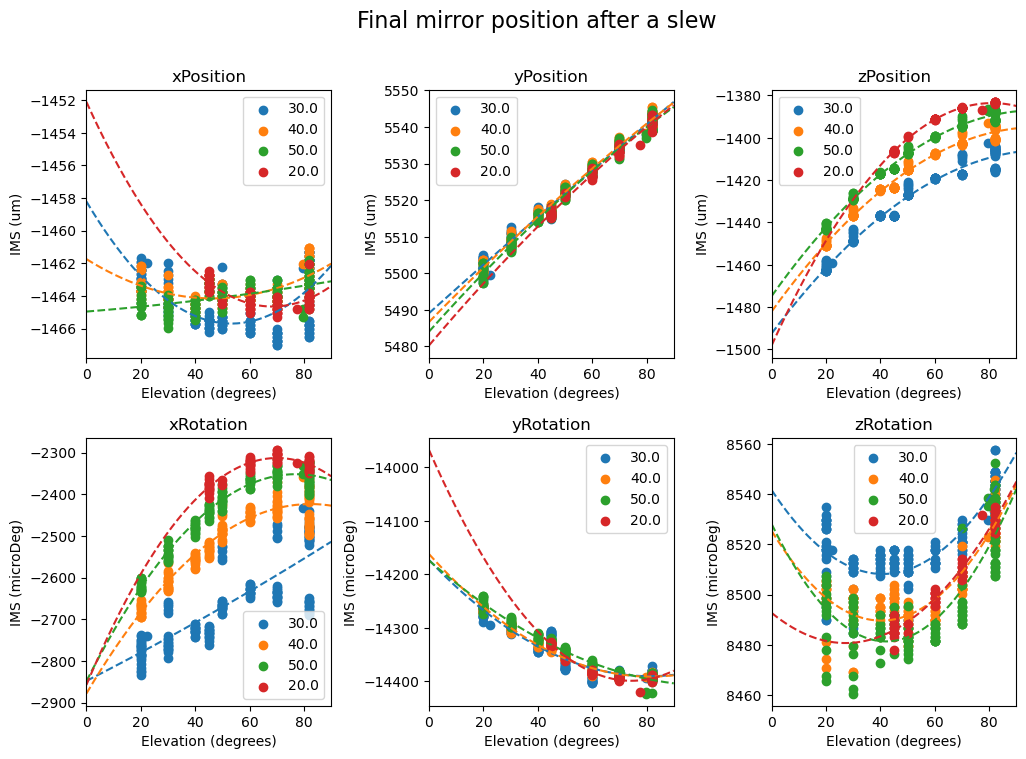

In [10]:
%matplotlib inline
names = ['xPosition', 'yPosition', 'zPosition', 'xRotation', 'yRotation', 'zRotation']
limits = [6.0, 6.0, 1.0, 24.0, 24.0, 24.0]

fig, axs = plt.subplots(2,3,figsize=(12,8))
plt.subplots_adjust(hspace=0.3, wspace=0.4)
plt.suptitle(f"Final mirror position after a slew", fontsize=16)
plot_counter = 0
for i in range(2):
    for j in range(3):
        if plot_counter > 2:
            unit = 'microDeg'
        else:
            unit = 'um'
        for dayObs in data.keys():
            [els, azs, times, temps, elLimits, azLimits, plots] = data[dayObs] 

            axs[i][j].set_title(names[plot_counter])
            axs[i][j].set_xlim(0, 90)
            axs[i][j].set_xlabel("Elevation (degrees)")
            axs[i][j].set_ylabel(f'IMS ({unit})')
            for m, azLimit in enumerate(azMaxLimits):
                theseEls = []
                theseData = []
                for n in range(len(els)):
                    if abs(azLimits[n] - azLimit) < 0.1:
                        theseEls.append(els[n])
                        theseData.append(plots[plot_counter][n])
                
                axs[i][j].scatter(theseEls, theseData, label=azLimit)
                fit = np.polyfit(theseEls, theseData, 2)
                #print(azLimit, fit)
                xplot = np.linspace(0.0, 90.0, 1000)
                yplot = np.polyval(fit, xplot)
                axs[i][j].plot(xplot, yplot, ls='--')

                axs[i][j].legend()
        plot_counter += 1

plt.savefig(str(data_dir / f"Final_Mirror_Position_{dayObs}.png"))

# Now select the data associated with zPosition only
## We will use this to fit a model, with and without temperature compensation.

In [11]:
plot_counter = 2 # Selects zPosition only
theseEls = []
theseData = []
theseTemps = []
theseTimes = []
[els, azs, times, temps, elLimits, azLimits, plots] = data[dayObs] 

for m, azLimit in enumerate(azMaxLimits):
    for n in range(len(els)):
        if abs(azLimits[n] - azLimit) < 0.1:
            theseTimes.append(times[n])
            theseEls.append(els[n])
            theseData.append(plots[plot_counter][n])
            theseTemps.append(temps[n])


# Now fit the zPosition vs elevation, with and without temperature compensation

In [12]:
from scipy.optimize import minimize

def func1(params, args):
    # No temperature compensation
    [const, El1, El2] = params
    [els, data, temps] = args
    diff = data - (const + El1 * els + El2 * els * els)
    return np.sum(diff * diff)

def func2(params, args):
    # With temperature compensation
    [const, El1, El2, T1] = params
    [els, data, temps] = args
    diff = data - (const + El1 * els + El2 * els * els + T1 * temps)
    return np.sum(diff * diff)

args = [np.array(theseEls), np.array(theseData), np.array(theseTemps)]
param0 = [-700, 1.7, -.01, -60.0]
Tparams = minimize(func2, param0, args=args, method='Powell').x
param0 = [-700, 1.7, -.01]
NoTparams = minimize(func1, param0, args=args, method='Powell').x

# Now plot the fit, with and without temperature compensation

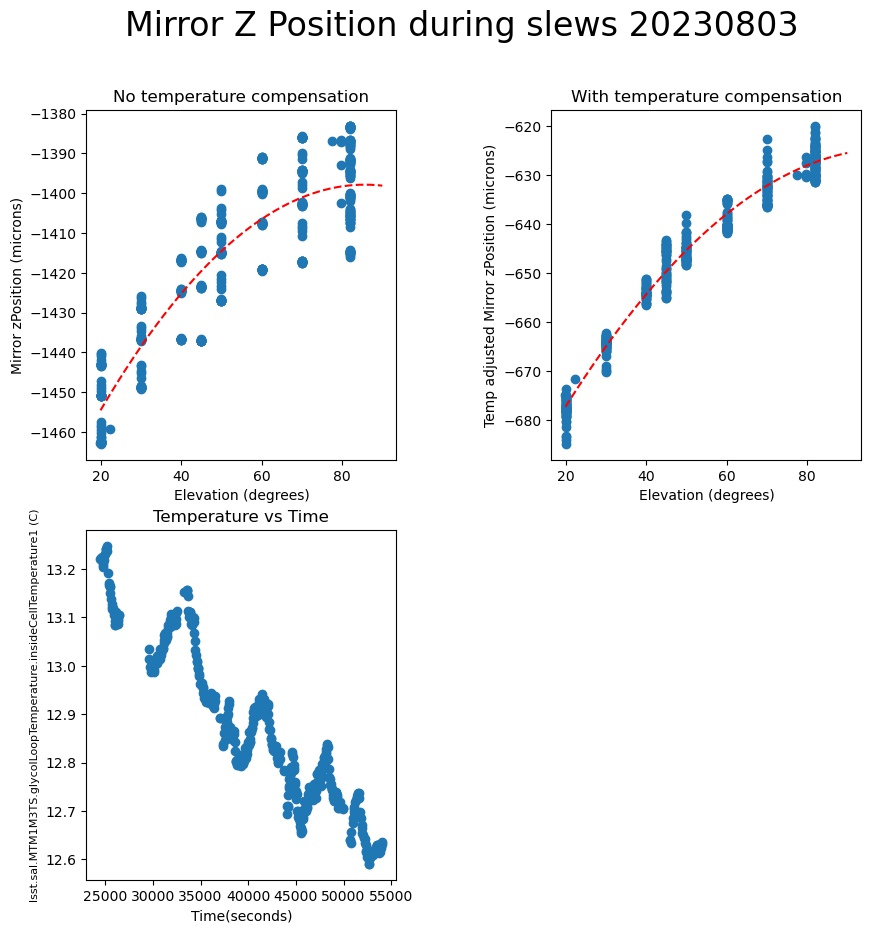

In [13]:
fig, axs = plt.subplots(2,2,figsize = (10,10))
plt.subplots_adjust(wspace = 0.5)
plt.suptitle("Mirror Z Position during slews 20230803", fontsize = 24)

axs[0][0].set_title("No temperature compensation")
axs[0][0].scatter(theseEls, theseData)
axs[0][0].set_xlabel("Elevation (degrees)")
axs[0][0].set_ylabel("Mirror zPosition (microns)")
xs = np.linspace(20,90,1000)
ys = NoTparams[0] + NoTparams[1] * xs + NoTparams[2] * xs * xs
axs[0][0].plot(xs, ys, ls = '--', color='red')

axs[0][1].set_title("With temperature compensation")
axs[0][1].scatter(theseEls, theseData - Tparams[3] * np.array(theseTemps))
axs[0][1].set_xlabel("Elevation (degrees)")
axs[0][1].set_ylabel("Temp adjusted Mirror zPosition (microns)")
xs = np.linspace(20,90,1000)
ys = Tparams[0] + Tparams[1] * xs + Tparams[2] * xs * xs
axs[0][1].plot(xs, ys, ls = '--', color='red')

axs[1][0].set_title("Temperature vs Time")
axs[1][0].scatter(theseTimes, theseTemps)
axs[1][0].set_xlabel("Time(seconds)")
axs[1][0].set_ylabel("lsst.sal.MTM1M3TS.glycolLoopTemperature.insideCellTemperature1 (C)", fontsize=8)

axs[1][1].axis('off')

plt.savefig(str(data_dir / f"Mirror_Position_Temperature_{dayObs}.png"))